In [2]:
require 'nn'
require 'rnn'
require 'getData'
require 'optim'
require 'cutorch'
require 'cunn'
require 'PrintIdentity'
require 'FastLSTM_padding'
image = require 'image'

model = require 'model'
Train = require 'train'
Utils = require 'utils'
cjson = require "cjson"
model_utils = require 'model_utils'

In [3]:
-- hyper-parameters
batchSize = 4
rho = 34 -- sequence length
hiddenSize = 512
projectSize = 1
convFeatureSize = 512
numConvFeature = 196
nIndex = 5305 -- input words
nClass = 2 -- output classes
nEpoch = 200
fcSize = 4096

In [4]:
ds_test = Utils.loadData('test', false)
protos = torch.load('./model/nEpoch_4_04_23_2016_19_02_31.net')

loading testing data...	
../data/dataset_v7w_telling_tokenized_test.json	


In [5]:
clones = {}
clones['lstm'] = model_utils.clone_many_times(protos.lstm, rho+1, not protos.lstm.parameters)
clones['wordEmbed'] = model_utils.clone_many_times(protos.wordEmbed, rho, not protos.wordEmbed.parameters)
clones['attention'] = model_utils.clone_many_times(protos.attention, rho+1, not protos.attention.parameters)

In [6]:
function kron(A,B)
    local m, n = A:size(1), A:size(2)
    local p, q = B:size(1), B:size(2)
    local C = torch.Tensor(m*p,n*q)

    for i=1,m do
        for j=1,n do
            C[{{(i-1)*p+1,i*p},{(j-1)*q+1,j*q}}] = torch.mul(B, A[i][j])
        end
    end
    return C
end

In [7]:
function evaluateOneQuestion(qid)
    image_size = 420
    
    start_idx = (qid-1) * batchSize+1
    end_idx = qid * batchSize
    if end_idx > ds_test.size then
        end_idx = ds_test.size
    end
    words, fc7, conv4, mask, targets = torch.LongTensor(),torch.LongTensor(),torch.LongTensor(), torch.LongTensor(), torch.LongTensor()
    words, fc7, conv4, mask, targets = words:cuda(), fc7:cuda(), conv4:cuda(), mask:cuda(), targets:cuda()
    inputs = Utils.getNextBatch(ds_test, ds_test.indices, qid, words, fc7, conv4, mask, targets)
    words = inputs[1]
    fc7 = inputs[2]
    conv4 = inputs[3]
    mask = inputs[4]
    totalInput = {fc7, words, conv4, mask}
    -- forward step
    totalOutput, err, at = Train.forward(clones, protos, totalInput, targets, batchSize)
    outputs = totalOutput[6]

    val, id = torch.max(outputs:sub(1, 4), 1)
    img_id = ds_test.img_id[start_idx + id[1][2] - 1]
    im = image.load('../images/v7w_' .. tostring(img_id) .. '.jpg')
    step = 2
    overlap = {}
    heatmap = {}
    im = image.scale(im, image_size, image_size)
    itorch.image(im)
    --im = im/torch.max(im) 
    print('Question: ' .. ds_test.question[start_idx + id[1][2] - 1])
    print('Our Answer: ' .. ds_test.choices[start_idx  + id[1][2] - 1])
    for c = start_idx, end_idx do
        print('Choices: ' .. ds_test.choices[c])
    end
    --print('Gold Standard: ' .. ds_test.answer[start_idx + id[1][2] - 1])
    for step = 25,35 do
        attendWeight = at[step]:narrow(1,id[1][2],1):squeeze():view(14,14)
        --print(torch.sum(attendWeight))
        attendWeight = torch.log(attendWeight)
        attendWeight = attendWeight - torch.min(attendWeight)
        attendWeight = torch.exp(attendWeight*5)
        --print(torch.exp(attendWeight*100))
        --attendWeight = attendWeight/torch.max(attendWeight)
        tmpheatmap = kron(attendWeight, torch.ones(image_size/14,image_size/14)):view(1, image_size, image_size)
        tmpheatmap = torch.expand(tmpheatmap, 3, image_size, image_size)       
        table.insert(overlap, torch.cmul(im*1.5,tmpheatmap))
        table.insert(heatmap, tmpheatmap)
    end
    figure = {}
    --table.insert(figure, im/torch.max(im))
    table.insert(figure, heatmap[#heatmap-1])
    table.insert(figure, overlap[#overlap-1])
    itorch.image(figure)
    itorch.image(heatmap)
end

Question: how many people are there?	
Our Answer: one.	
Choices: two.	
Choices: nine.	
Choices: seven.	
Choices: one.	


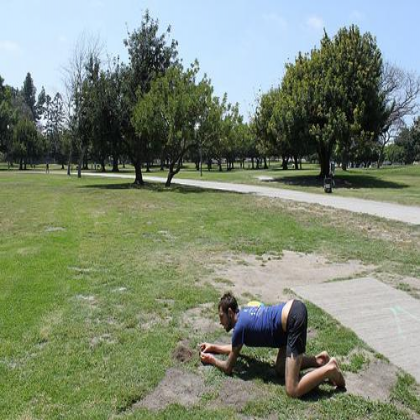

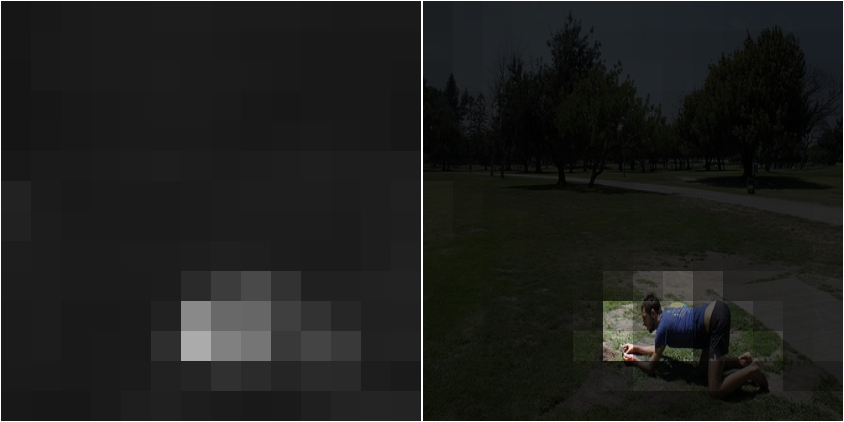

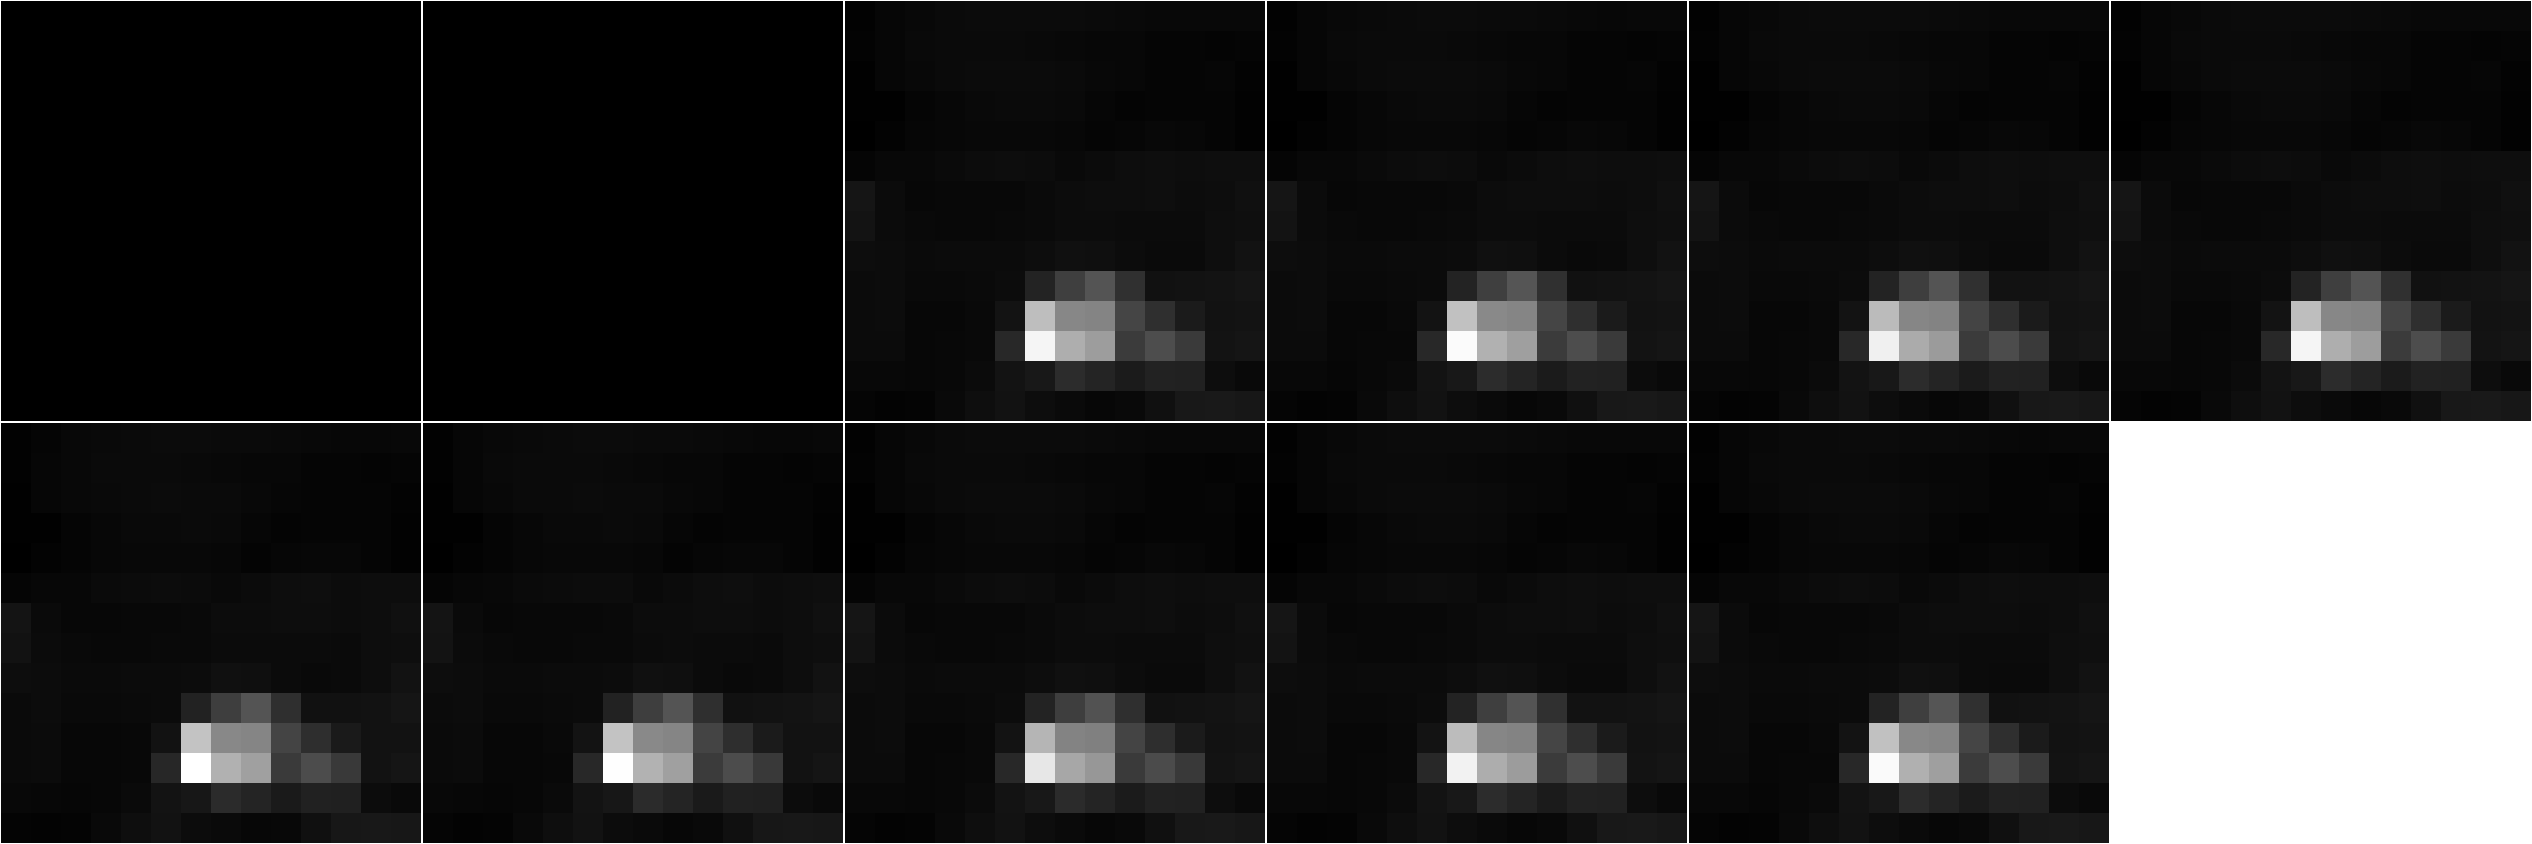

In [112]:
evaluateOneQuestion(18430)

In [113]:
print(outputs)

-0.6513 -0.7368
-0.1858 -1.7745
-0.1055 -2.3015
-1.1622 -0.3751
[torch.CudaTensor of size 4x2]

